# NYC Taxi trip duration

Demo of Bayesian optimization. The features and model are inspired by https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-367, but was simplified to illustrate BayesOpt instead.

In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [2]:
train = pd.read_csv('input/nyc-taxi-trip-duration/train.csv')
test = pd.read_csv('input/nyc-taxi-trip-duration/test.csv')

In [3]:
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)
train.loc[:, 'pickup_date'] = train['pickup_datetime'].dt.date
test.loc[:, 'pickup_date'] = test['pickup_datetime'].dt.date
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)
train['store_and_fwd_flag'] = 1 * (train.store_and_fwd_flag.values == 'Y')
test['store_and_fwd_flag'] = 1 * (test.store_and_fwd_flag.values == 'Y')
train['check_trip_duration'] = (train['dropoff_datetime'] - train['pickup_datetime']).map(lambda x: x.total_seconds())
duration_difference = train[np.abs(train['check_trip_duration'].values  - train['trip_duration'].values) > 1]
print('Trip_duration and datetimes are ok.') if len(duration_difference[['pickup_datetime', 'dropoff_datetime', 'trip_duration', 'check_trip_duration']]) == 0 else print('Ooops.')

# Convert trip duration into the log domain, and use RMSE to train the model
train['log_trip_duration'] = np.log(train['trip_duration'].values + 1)

Trip_duration and datetimes are ok.


## Feature Extraction

In [4]:
# PCA
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values,
                    test[['pickup_latitude', 'pickup_longitude']].values,
                    test[['dropoff_latitude', 'dropoff_longitude']].values))

pca = PCA().fit(coords)
train['pickup_pca0'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 0]
train['pickup_pca1'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 1]
train['dropoff_pca0'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
train['dropoff_pca1'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 1]
test['pickup_pca0'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 0]
test['pickup_pca1'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 1]
test['dropoff_pca0'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
test['dropoff_pca1'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 1]

In [5]:
# Distances
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

train.loc[:, 'distance_haversine'] = haversine_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:, 'direction'] = bearing_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:, 'pca_manhattan'] = np.abs(train['dropoff_pca1'] - train['pickup_pca1']) + np.abs(train['dropoff_pca0'] - train['pickup_pca0'])

test.loc[:, 'distance_haversine'] = haversine_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:, 'direction'] = bearing_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:, 'pca_manhattan'] = np.abs(test['dropoff_pca1'] - test['pickup_pca1']) + np.abs(test['dropoff_pca0'] - test['pickup_pca0'])

train.loc[:, 'center_latitude'] = (train['pickup_latitude'].values + train['dropoff_latitude'].values) / 2
train.loc[:, 'center_longitude'] = (train['pickup_longitude'].values + train['dropoff_longitude'].values) / 2
test.loc[:, 'center_latitude'] = (test['pickup_latitude'].values + test['dropoff_latitude'].values) / 2
test.loc[:, 'center_longitude'] = (test['pickup_longitude'].values + test['dropoff_longitude'].values) / 2

In [6]:
# Datetime
train.loc[:, 'pickup_weekday'] = train['pickup_datetime'].dt.weekday
train.loc[:, 'pickup_hour_weekofyear'] = train['pickup_datetime'].dt.weekofyear
train.loc[:, 'pickup_hour'] = train['pickup_datetime'].dt.hour
train.loc[:, 'pickup_minute'] = train['pickup_datetime'].dt.minute
train.loc[:, 'pickup_dt'] = (train['pickup_datetime'] - train['pickup_datetime'].min()).dt.total_seconds()
train.loc[:, 'pickup_week_hour'] = train['pickup_weekday'] * 24 + train['pickup_hour']

test.loc[:, 'pickup_weekday'] = test['pickup_datetime'].dt.weekday
test.loc[:, 'pickup_hour_weekofyear'] = test['pickup_datetime'].dt.weekofyear
test.loc[:, 'pickup_hour'] = test['pickup_datetime'].dt.hour
test.loc[:, 'pickup_minute'] = test['pickup_datetime'].dt.minute
test.loc[:, 'pickup_dt'] = (test['pickup_datetime'] - train['pickup_datetime'].min()).dt.total_seconds()
test.loc[:, 'pickup_week_hour'] = test['pickup_weekday'] * 24 + test['pickup_hour']

In [7]:
# Speed
train.loc[:, 'avg_speed_h'] = 1000 * train['distance_haversine'] / train['trip_duration']
train.loc[:, 'avg_speed_m'] = 1000 * train['distance_dummy_manhattan'] / train['trip_duration']

train.loc[:, 'pickup_lat_bin'] = np.round(train['pickup_latitude'], 3)
train.loc[:, 'pickup_long_bin'] = np.round(train['pickup_longitude'], 3)
# Average speed for regions
gby_cols = ['pickup_lat_bin', 'pickup_long_bin']
coord_speed = train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
coord_count = train.groupby(gby_cols).count()[['id']].reset_index()
coord_stats = pd.merge(coord_speed, coord_count, on=gby_cols)
coord_stats = coord_stats[coord_stats['id'] > 100]

train.loc[:, 'pickup_lat_bin'] = np.round(train['pickup_latitude'], 2)
train.loc[:, 'pickup_long_bin'] = np.round(train['pickup_longitude'], 2)
train.loc[:, 'center_lat_bin'] = np.round(train['center_latitude'], 2)
train.loc[:, 'center_long_bin'] = np.round(train['center_longitude'], 2)
train.loc[:, 'pickup_dt_bin'] = (train['pickup_dt'] // (3 * 3600))
test.loc[:, 'pickup_lat_bin'] = np.round(test['pickup_latitude'], 2)
test.loc[:, 'pickup_long_bin'] = np.round(test['pickup_longitude'], 2)
test.loc[:, 'center_lat_bin'] = np.round(test['center_latitude'], 2)
test.loc[:, 'center_long_bin'] = np.round(test['center_longitude'], 2)
test.loc[:, 'pickup_dt_bin'] = (test['pickup_dt'] // (3 * 3600))

In [8]:
# Clustering
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])

train.loc[:, 'pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
test.loc[:, 'pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

In [9]:
# Temporal and geospatial
for gby_col in ['pickup_hour', 'pickup_date', 'pickup_dt_bin',
               'pickup_week_hour', 'pickup_cluster', 'dropoff_cluster']:
    gby = train.groupby(gby_col).mean()[['avg_speed_h', 'avg_speed_m', 'log_trip_duration']]
    gby.columns = ['%s_gby_%s' % (col, gby_col) for col in gby.columns]
    train = pd.merge(train, gby, how='left', left_on=gby_col, right_index=True)
    test = pd.merge(test, gby, how='left', left_on=gby_col, right_index=True)

for gby_cols in [['center_lat_bin', 'center_long_bin'],
                 ['pickup_hour', 'center_lat_bin', 'center_long_bin'],
                 ['pickup_hour', 'pickup_cluster'],  ['pickup_hour', 'dropoff_cluster'],
                 ['pickup_cluster', 'dropoff_cluster']]:
    coord_speed = train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
    coord_count = train.groupby(gby_cols).count()[['id']].reset_index()
    coord_stats = pd.merge(coord_speed, coord_count, on=gby_cols)
    coord_stats = coord_stats[coord_stats['id'] > 100]
    coord_stats.columns = gby_cols + ['avg_speed_h_%s' % '_'.join(gby_cols), 'cnt_%s' %  '_'.join(gby_cols)]
    train = pd.merge(train, coord_stats, how='left', on=gby_cols)
    test = pd.merge(test, coord_stats, how='left', on=gby_cols)
    
group_freq = '60min'
df_all = pd.concat((train, test))[['id', 'pickup_datetime', 'pickup_cluster', 'dropoff_cluster']]
train.loc[:, 'pickup_datetime_group'] = train['pickup_datetime'].dt.round(group_freq)
test.loc[:, 'pickup_datetime_group'] = test['pickup_datetime'].dt.round(group_freq)

# Count trips over 60min
df_counts = df_all.set_index('pickup_datetime')[['id']].sort_index()
df_counts['count_60min'] = df_counts.isnull().rolling(group_freq).count()['id']
train = train.merge(df_counts, on='id', how='left')
test = test.merge(df_counts, on='id', how='left')

# Count how many trips are going to each cluster over time
dropoff_counts = df_all \
    .set_index('pickup_datetime') \
    .groupby([pd.TimeGrouper(group_freq), 'dropoff_cluster']) \
    .agg({'id': 'count'}) \
    .reset_index().set_index('pickup_datetime') \
    .groupby('dropoff_cluster').rolling('240min').mean() \
    .drop('dropoff_cluster', axis=1) \
    .reset_index().set_index('pickup_datetime').shift(freq='-120min').reset_index() \
    .rename(columns={'pickup_datetime': 'pickup_datetime_group', 'id': 'dropoff_cluster_count'})

train['dropoff_cluster_count'] = train[['pickup_datetime_group', 'dropoff_cluster']].merge(dropoff_counts, on=['pickup_datetime_group', 'dropoff_cluster'], how='left')['dropoff_cluster_count'].fillna(0)
test['dropoff_cluster_count'] = test[['pickup_datetime_group', 'dropoff_cluster']].merge(dropoff_counts, on=['pickup_datetime_group', 'dropoff_cluster'], how='left')['dropoff_cluster_count'].fillna(0)

# Count how many trips are going from each cluster over time
df_all = pd.concat((train, test))[['id', 'pickup_datetime', 'pickup_cluster', 'dropoff_cluster']]
pickup_counts = df_all \
    .set_index('pickup_datetime') \
    .groupby([pd.TimeGrouper(group_freq), 'pickup_cluster']) \
    .agg({'id': 'count'}) \
    .reset_index().set_index('pickup_datetime') \
    .groupby('pickup_cluster').rolling('240min').mean() \
    .drop('pickup_cluster', axis=1) \
    .reset_index().set_index('pickup_datetime').shift(freq='-120min').reset_index() \
    .rename(columns={'pickup_datetime': 'pickup_datetime_group', 'id': 'pickup_cluster_count'})

train['pickup_cluster_count'] = train[['pickup_datetime_group', 'pickup_cluster']].merge(pickup_counts, on=['pickup_datetime_group', 'pickup_cluster'], how='left')['pickup_cluster_count'].fillna(0)
test['pickup_cluster_count'] = test[['pickup_datetime_group', 'pickup_cluster']].merge(pickup_counts, on=['pickup_datetime_group', 'pickup_cluster'], how='left')['pickup_cluster_count'].fillna(0)

In [10]:
# OSRM features
fr1 = pd.read_csv('input/new-york-city-taxi-with-osrm/fastest_routes_train_part_1.csv', usecols=['id', 'total_distance', 'total_travel_time',  'number_of_steps'])
fr2 = pd.read_csv('input/new-york-city-taxi-with-osrm/fastest_routes_train_part_2.csv', usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])
test_street_info = pd.read_csv('input/new-york-city-taxi-with-osrm/fastest_routes_test.csv',
                               usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])
train_street_info = pd.concat((fr1, fr2))
train = train.merge(train_street_info, how='left', on='id')
test = test.merge(test_street_info, how='left', on='id')

feature_names = list(train.columns)
print(np.setdiff1d(train.columns, test.columns))
do_not_use_for_training = ['id', 'log_trip_duration', 'pickup_datetime', 'dropoff_datetime', 'trip_duration', 'check_trip_duration',
                           'pickup_date', 'avg_speed_h', 'avg_speed_m', 'pickup_lat_bin', 'pickup_long_bin',
                           'center_lat_bin', 'center_long_bin', 'pickup_dt_bin', 'pickup_datetime_group']
feature_names = [f for f in train.columns if f not in do_not_use_for_training]
# print(feature_names)
print('We have %i features.' % len(feature_names))
train[feature_names].count()
y = np.log(train['trip_duration'].values + 1)

['avg_speed_h' 'avg_speed_m' 'check_trip_duration' 'dropoff_datetime'
 'log_trip_duration' 'trip_duration']
We have 59 features.


In [11]:
# Sanity check
feature_stats = pd.DataFrame({'feature': feature_names})
feature_stats.loc[:, 'train_mean'] = np.nanmean(train[feature_names].values, axis=0).round(4)
feature_stats.loc[:, 'test_mean'] = np.nanmean(test[feature_names].values, axis=0).round(4)
feature_stats.loc[:, 'train_std'] = np.nanstd(train[feature_names].values, axis=0).round(4)
feature_stats.loc[:, 'test_std'] = np.nanstd(test[feature_names].values, axis=0).round(4)
feature_stats.loc[:, 'train_nan'] = np.mean(np.isnan(train[feature_names].values), axis=0).round(3)
feature_stats.loc[:, 'test_nan'] = np.mean(np.isnan(test[feature_names].values), axis=0).round(3)
feature_stats.loc[:, 'train_test_mean_diff'] = np.abs(feature_stats['train_mean'] - feature_stats['test_mean']) / np.abs(feature_stats['train_std'] + feature_stats['test_std'])  * 2
feature_stats.loc[:, 'train_test_nan_diff'] = np.abs(feature_stats['train_nan'] - feature_stats['test_nan'])
feature_stats = feature_stats.sort_values(by='train_test_mean_diff')
feature_stats[['feature', 'train_test_mean_diff']].tail()

,feature,train_test_mean_diff
38,avg_speed_m_gby_pickup_cluster,0.002815
10,dropoff_pca1,0.002833
18,pickup_hour_weekofyear,0.002872
50,cnt_pickup_hour_dropoff_cluster,0.003014
49,avg_speed_h_pickup_hour_dropoff_cluster,0.003072


In [12]:
feature_stats = feature_stats.sort_values(by='train_test_nan_diff')
feature_stats[['feature', 'train_nan', 'test_nan', 'train_test_nan_diff']].tail()

,feature,train_nan,test_nan,train_test_nan_diff
48,cnt_pickup_hour_pickup_cluster,0.017,0.016,0.001
50,cnt_pickup_hour_dropoff_cluster,0.018,0.019,0.001
49,avg_speed_h_pickup_hour_dropoff_cluster,0.018,0.019,0.001
51,avg_speed_h_pickup_cluster_dropoff_cluster,0.105,0.107,0.002
52,cnt_pickup_cluster_dropoff_cluster,0.105,0.107,0.002


In [13]:
Xtr, Xv, ytr, yv = train_test_split(train[feature_names].values, y, test_size=0.2, random_state=1987)
dtrain = xgb.DMatrix(Xtr, label=ytr)
dvalid = xgb.DMatrix(Xv, label=yv)
dtest = xgb.DMatrix(test[feature_names].values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

## Modeling

In [14]:
# Try different parameters! My favorite is random search :)
#xgb_pars = {'min_child_weight': 50, 'eta': 0.3, 'colsample_bytree': 0.3, 'max_depth': 10,
#            'subsample': 0.8, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
#            'eval_metric': 'rmse', 'objective': 'reg:linear'}

xgb_pars = dict(base_score=0.94442985032389859, booster='gbtree',
                colsample_bylevel=0.98585604769455193,
                colsample_bytree=0.92445691213304193, gamma=0.072172952116487318,
                learning_rate=0.047960999030042195, max_delta_step=6,
                max_depth=11, min_child_weight=137, n_estimators=44,
                reg_alpha=0.11089082081183133, reg_lambda=0.43933650186577011,
                scale_pos_weight=0.84464184630556982, subsample=0.94788179783675974,
                eval_metric='rmse', objective='reg:linear')
            
model = xgb.train(xgb_pars, dtrain, num_boost_round=60, evals=watchlist, early_stopping_rounds=50,
                  maximize=False, verbose_eval=10)

print('Modeling RMSLE %.5f' % model.best_score)

[0]	train-rmse:5.31831	valid-rmse:5.31922
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:3.2713	valid-rmse:3.27278
[20]	train-rmse:2.02513	valid-rmse:2.02761
[30]	train-rmse:1.2756	valid-rmse:1.27981
[40]	train-rmse:0.835676	valid-rmse:0.842571
[50]	train-rmse:0.590331	valid-rmse:0.600783
[59]	train-rmse:0.473362	valid-rmse:0.48711
Modeling RMSLE 0.48711


In [15]:
yv

array([ 7.36137543,  6.66185474,  5.73009978, ...,  5.7170277 ,
        5.50938834,  6.99576616])

---

# Hyper-parameter Optimization

XGBoost has [many parameters](https://github.com/dmlc/xgboost/blob/master/doc/parameter.md), but in practice we should
only tune a managable number of hyper-parameters. In this section, we will tune the following:

- learning_rate: [0.001, 0.4]
- gamma: (0, 3]
- colsample_bytree: (0, 1]
- reg_lambda: (0, 1]

Those are all continuous, because some optimizers only accept continuous variables.

In [14]:
from hyper_optimizer import Parameter, HyperBaseEstimator

class XGBoostEstimator(HyperBaseEstimator):
    def __init__(self, learning_rate=0.1, gamma=0, colsample_bytree=1, reg_lambda=1):
        super(XGBoostEstimator, self).__init__(learning_rate=learning_rate, gamma=gamma,
                                               colsample_bytree=colsample_bytree, reg_lambda=reg_lambda)
        self.model_ = None
        
    def predict(self, X, y=None):
        import xgboost as xgb
        return self.model_.predict(xgb.DMatrix(X, label=y))

    def fit(self, X, y=None):
        import xgboost as xgb
        dtrain = xgb.DMatrix(X, label=y)
        watchlist = [(dtrain, 'train')]

        xgb_pars = dict(learning_rate=self.learning_rate, gamma=self.gamma, subsample=1,
                        colsample_bytree=self.colsample_bytree, reg_lambda=self.reg_lambda,
                        base_score=0.5, booster='gbtree', colsample_bylevel=1,
                        max_delta_step=0, max_depth=18, min_child_weight=1, 
                        n_estimators=180, reg_alpha=0, scale_pos_weight=1, 
                        n_jobs=2, eval_metric='rmse', objective='reg:linear', random_state=42, missing=None)
            
        self.model_ = xgb.train(xgb_pars, dtrain, num_boost_round=60, evals=watchlist, 
                                early_stopping_rounds=50, maximize=False, verbose_eval=50)

    def score(self, X, y=None):
        # the library will maximize the return value of this function,
        # so we are gonna return the negated score of the regressor
        from sklearn.metrics import mean_squared_error
        import math
        y_pred = self.predict(X, y)
        return -math.sqrt(mean_squared_error(y_pred, y))
    
params = [Parameter('learning_rate', Parameter.DOUBLE, min_bound=0.001, max_bound=0.4),
          Parameter('gamma', Parameter.DOUBLE, min_bound=0.0, max_bound=3.0),
          Parameter('colsample_bytree', Parameter.DOUBLE, min_bound=0.5, max_bound=1.0),
          Parameter('reg_lambda', Parameter.DOUBLE, min_bound=0.0, max_bound=1.0)]

In [15]:
def draw_avg_test_score(history, ylim=(-0.55, -0.35)):
    import matplotlib.pyplot as plt
    y = [e.test_scores[0] for e in history.entries]
    f = plt.figure(figsize=(20, 5))
    plt.plot(range(len(history.entries)), y)
    plt.ylim(ylim[0], ylim[1])
    plt.grid()
    return f

### Random Optimizer

In [16]:
from hyper_optimizer import RandomOptimizer
import time

t = time.time()
random_opt = RandomOptimizer(estimator=XGBoostEstimator(), params=params, max_trials=40, cv=(Xv, yv),
                     random_state=42, n_jobs=1)
random_opt.fit(Xtr, ytr)
print('Total time: {}'.format(time.time() - t))

[0]	train-rmse:4.2655
Will train until train-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.270625
[59]	train-rmse:0.269023
[0]	train-rmse:5.87483
Will train until train-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.76498
[59]	train-rmse:1.43126
[0]	train-rmse:5.96444
Will train until train-rmse hasn't improved in 50 rounds.
[50]	train-rmse:3.76788
[59]	train-rmse:3.47012
[0]	train-rmse:5.57885
Will train until train-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.25856
[59]	train-rmse:0.227705
[0]	train-rmse:4.9813
Will train until train-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.247869
[59]	train-rmse:0.24573
[0]	train-rmse:5.31531
Will train until train-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.195491
[59]	train-rmse:0.187775
[0]	train-rmse:5.53641
Will train until train-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.295571
[59]	train-rmse:0.280347
[0]	train-rmse:4.56147
Will train until train-rmse hasn't improved in 50 rounds.
[50]	train

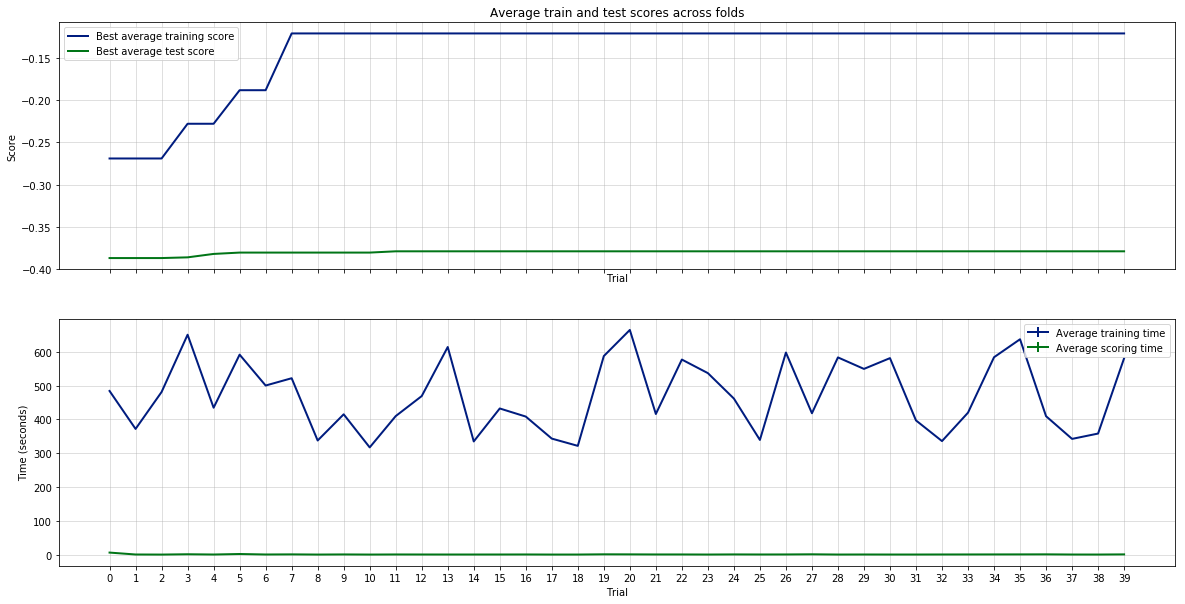

In [21]:
random_opt.history_.plot()

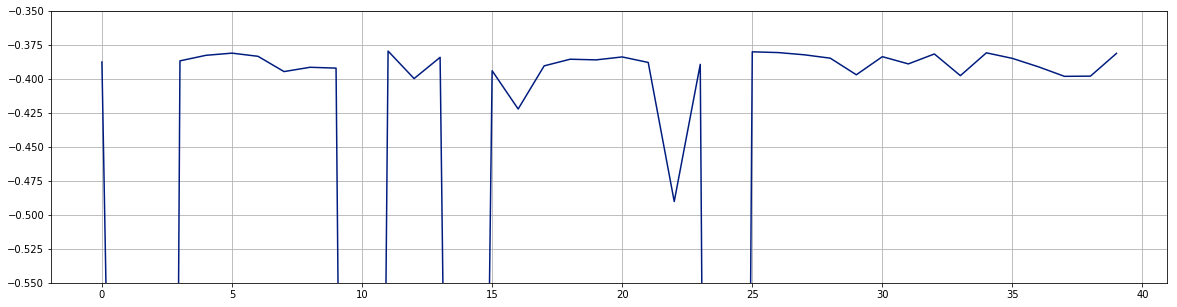

In [22]:
draw_avg_test_score(random_opt.history_)

In [23]:
random_opt.best_test_score_

-0.37949398950846003

In [24]:
random_opt.best_estimator_

XGBoostEstimator(colsample_bytree=0.62938999080000846,
         gamma=1.9875668530619459, learning_rate=0.12537271935967498,
         reg_lambda=0.52006802117781081)

In [33]:
import pandas as pd

random_df = pd.DataFrame(data=[dict(**(e.params), avg_test_score=e.test_scores[0],
                                    avg_train_score=e.train_scores[0],
                                   avg_fit_time=e.fit_times[0],
                                   avg_score_time=e.score_times[0]) for e in random_opt.history_.entries])
random_df = random_df.sort_values('avg_test_score', ascending=False)
random_df.to_csv('models/random.csv')
random_df

,avg_fit_time,avg_score_time,avg_test_score,avg_train_score,colsample_bytree,gamma,learning_rate,reg_lambda
11,409.675454,0.696273,-0.379494,-0.261649,0.629390,1.987567,0.125373,0.520068
25,339.216738,0.622166,-0.380036,-0.261583,0.515715,1.909231,0.126428,0.508571
26,597.517459,0.718784,-0.380592,-0.213637,0.953783,0.747877,0.164743,0.755551
34,583.642308,0.804579,-0.380772,-0.265412,0.759395,2.109057,0.146088,0.971782
5,591.331893,2.050386,-0.381009,-0.187775,0.805926,0.418482,0.117566,0.366362
39,580.622859,0.924693,-0.381191,-0.274705,0.836068,2.284859,0.095817,0.728216
32,335.822221,0.649492,-0.381619,-0.245459,0.503476,1.532242,0.167547,0.222108
27,418.089006,1.171297,-0.382226,-0.155898,0.614399,0.230940,0.116611,0.161221
4,434.489891,0.561527,-0.382605,-0.245730,0.652121,1.574269,0.173346,0.291229
6,500.044323,0.623854,-0.383342,-0.280347,0.728035,2.355528,0.080670,0.514234


### scikit-optimize

In [17]:
from hyper_optimizer import SkOptOptimizer
import time

t = time.time()
skopt_opt = SkOptOptimizer(estimator=XGBoostEstimator(), params=params, max_trials=40, cv=(Xv, yv),
                     random_state=42, n_jobs=1)
skopt_opt.fit(Xtr, ytr)
print('Total time: {}'.format(time.time() - t))

[0]	train-rmse:5.60089
Will train until train-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.316221
[59]	train-rmse:0.278365
[0]	train-rmse:5.60105
Will train until train-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.318266
[59]	train-rmse:0.280324
[0]	train-rmse:5.7396
Will train until train-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.613078
[59]	train-rmse:0.455434
[0]	train-rmse:5.60105
Will train until train-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.318266
[59]	train-rmse:0.280324
[0]	train-rmse:4.57568
Will train until train-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.247018
[59]	train-rmse:0.24517
[0]	train-rmse:4.5758
Will train until train-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.246833
[59]	train-rmse:0.24537
[0]	train-rmse:5.30907
Will train until train-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.240094
[59]	train-rmse:0.234186
[0]	train-rmse:5.30923
Will train until train-rmse hasn't improved in 50 rounds.
[50]	t

[59]	train-rmse:0.112732
[0]	train-rmse:5.39788
Will train until train-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.263429
[59]	train-rmse:0.255336
[0]	train-rmse:3.89881
Will train until train-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.271072
[59]	train-rmse:0.269773
[0]	train-rmse:5.39788
Will train until train-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.263429
[59]	train-rmse:0.255336
[0]	train-rmse:5.62386
Will train until train-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.338041
[59]	train-rmse:0.288431
[0]	train-rmse:5.39788
Will train until train-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.263429
[59]	train-rmse:0.255336
[0]	train-rmse:4.90369
Will train until train-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.26748
[59]	train-rmse:0.266055
[0]	train-rmse:5.39788
Will train until train-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.263429
[59]	train-rmse:0.255336
[0]	train-rmse:3.78253
Will train until train-rmse hasn't i

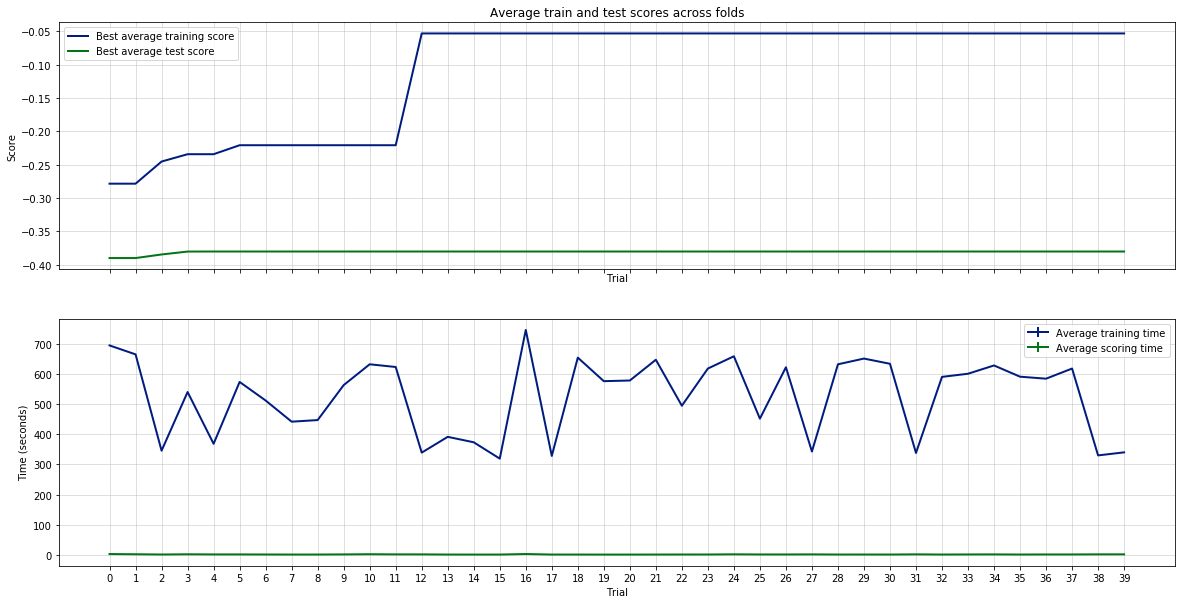

In [18]:
skopt_opt.history_.plot()

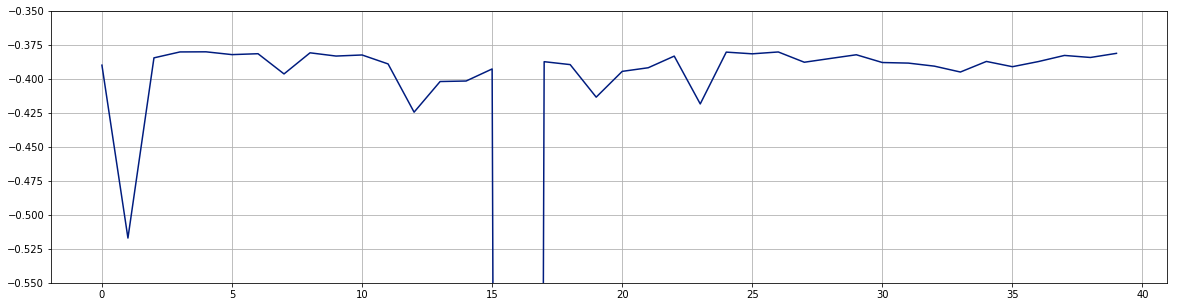

In [19]:
draw_avg_test_score(skopt_opt.history_)

In [20]:
skopt_opt.best_test_score_

-0.38003745897946478

In [21]:
skopt_opt.best_estimator_

XGBoostEstimator(colsample_bytree=0.55079246597943587,
         gamma=1.2941248958739688, learning_rate=0.10385502891862657,
         reg_lambda=0.77302197983336141)

In [22]:
import pandas as pd

skopt_df = pd.DataFrame(data=[dict(**(e.params), avg_test_score=e.test_scores[0],
                                   avg_train_score=e.train_scores[0],
                                   avg_fit_time=e.fit_times[0],
                                   avg_score_time=e.score_times[0]) for e in skopt_opt.history_.entries])
skopt_df = skopt_df.sort_values('avg_test_score', ascending=False)
skopt_df.to_csv('models/skopt.csv')
skopt_df

,avg_fit_time,avg_score_time,avg_test_score,avg_train_score,colsample_bytree,gamma,learning_rate,reg_lambda
4,368.542137,0.853635,-0.380037,-0.254328,0.550792,1.294125,0.103855,0.773022
3,540.681180,1.272804,-0.380120,-0.234186,0.836612,1.008668,0.118625,0.561328
26,622.923153,0.737448,-0.380144,-0.236736,1.000000,1.093179,0.126568,0.728788
24,659.411629,1.197904,-0.380256,-0.246415,1.000000,1.159739,0.105917,0.843602
8,447.405569,0.511387,-0.380768,-0.275655,0.696607,2.841050,0.157221,0.874846
39,340.090092,1.129415,-0.381162,-0.144848,0.500000,0.000000,0.129577,0.948657
6,512.407959,0.659867,-0.381434,-0.231357,0.772180,1.081783,0.186254,0.766788
25,452.067844,0.751462,-0.381509,-0.262559,0.717215,1.288450,0.084255,0.802510
5,574.097025,0.852199,-0.382093,-0.220711,0.800423,0.941065,0.154320,0.224732
29,651.805277,0.581411,-0.382202,-0.272645,1.000000,3.000000,0.137848,0.416237


In [23]:
import pickle
with open('models/skopt.pkl', 'wb') as f:
    pickle.dump(skopt_opt, f)

### Spearmint 

Spearmint expects the estimator to be loaded from a separated module, therefore we need some way to access to the source code of the estimator during runtime. We use the `inspect` module to do that, which would not work if the class is defined in the `__main__` context. Therefore we dump the source code into a separated file called `spearmint_estimator.py`.

In [16]:
with open('spearmint_estimator.py', 'w') as f:
    f.write("""
from hyper_optimizer import HyperBaseEstimator

class XGBoostEstimator(HyperBaseEstimator):
    def __init__(self, learning_rate=0.1, gamma=0, colsample_bytree=1, reg_lambda=1):
        super(XGBoostEstimator, self).__init__(learning_rate=learning_rate, gamma=gamma,
                                               colsample_bytree=colsample_bytree, reg_lambda=reg_lambda)
        self.model_ = None
        
    def predict(self, X, y=None):
        import xgboost as xgb
        return self.model_.predict(xgb.DMatrix(X, label=y))

    def fit(self, X, y=None):
        import xgboost as xgb
        dtrain = xgb.DMatrix(X, label=y)
        watchlist = [(dtrain, 'train')]

        xgb_pars = dict(learning_rate=self.learning_rate, gamma=self.gamma, subsample=1,
                        colsample_bytree=self.colsample_bytree, reg_lambda=self.reg_lambda,
                        base_score=0.5, booster='gbtree', colsample_bylevel=1,
                        max_delta_step=0, max_depth=18, min_child_weight=1, 
                        n_estimators=180, reg_alpha=0, scale_pos_weight=1, 
                        n_jobs=2, eval_metric='rmse', objective='reg:linear', random_state=42, missing=None)
            
        self.model_ = xgb.train(xgb_pars, dtrain, num_boost_round=60, evals=watchlist, 
                                early_stopping_rounds=50, maximize=False, verbose_eval=50)

    def score(self, X, y=None):
        # the library will maximize the return value of this function,
        # so we are gonna return the negated score of the regressor
        from sklearn.metrics import mean_squared_error
        import math
        y_pred = self.predict(X, y)
        return -math.sqrt(mean_squared_error(y_pred, y))
    """)

In [17]:
from hyper_optimizer import SpearmintOptimizer
import spearmint_estimator
import time

t = time.time()
spearmint_opt = SpearmintOptimizer(estimator=spearmint_estimator.XGBoostEstimator, 
                                   params=params, max_trials=40, cv=(Xv, yv),
                                   noisy_likelihood=True, db_address='localhost', expr_name='nyc-taxi-duration',
                                   overwrite_expr=True, polling_time=0, n_jobs=1)
spearmint_opt.fit(Xtr, ytr)
print('Total time: {}'.format(time.time() - t))

Experiment directory: /tmp/hyper_optimizer4tm0wo89nyc-taxi-duration
Not running from main.
Not running from main.


Using database at localhost.
/home/vu/code/hyper-optimizer/venv3/lib/python3.5/site-packages/spearmint/utils/database/mongodb.py:201: DeprecationWarning: last_status() is deprecated
  self.myId = self.db.last_status()['connectionId']
/home/vu/code/hyper-optimizer/venv3/lib/python3.5/site-packages/spearmint/utils/database/mongodb.py:256: DeprecationWarning: remove is deprecated. Use delete_one or delete_many instead.
  self.db[experiment_name][experiment_field].remove(field_filters)
Getting suggestion...

Suggestion:     NAME          TYPE       VALUE
                ----          ----       -----
                reg_lambda    float      0.000000    
                colsample_by  float      0.500000    
                gamma         float      0.000000    
                learning_rat  float      0.001000    
/home/vu/code/hyper-optimizer/venv3/lib/python3.5/site-packages/spearmint/utils/database/mongodb.py:232: DeprecationWarning: update is deprecated. Use replace_one, update_one or up

Fitting GP for main task...
/home/vu/code/hyper-optimizer/venv3/lib/python3.5/site-packages/spearmint/utils/database/mongodb.py:232: DeprecationWarning: update is deprecated. Use replace_one, update_one or update_many instead.
  result = dbcollection.update(field_filters, save_doc, upsert=upsert)
Getting suggestion...

Minimum expected objective value under model is 0.30330 (+/- 0.79918), at location:
                NAME          TYPE       VALUE
                ----          ----       -----
                reg_lambda    float      1.000000    
                colsample_by  float      0.962241    
                gamma         float      3.000000    
                learning_rat  float      0.400000    

Minimum of observed values is 0.382233, at location:
                NAME          TYPE       VALUE
                ----          ----       -----
                reg_lambda    float      0.500000    
                colsample_by  float      0.750000    
                gamma        


Minimum expected objective value under model is 0.37713 (+/- 0.09423), at location:
                NAME          TYPE       VALUE
                ----          ----       -----
                reg_lambda    float      0.819580    
                colsample_by  float      0.999390    
                gamma         float      2.118896    
                learning_rat  float      0.238004    

Minimum of observed values is 0.382233, at location:
                NAME          TYPE       VALUE
                ----          ----       -----
                reg_lambda    float      0.500000    
                colsample_by  float      0.750000    
                gamma         float      1.500000    
                learning_rat  float      0.200500    

Suggestion:     NAME          TYPE       VALUE
                ----          ----       -----
                reg_lambda    float      0.986203    
                colsample_by  float      1.000000    
                gamma         float   


Minimum expected objective value under model is 0.35135 (+/- 0.07597), at location:
                NAME          TYPE       VALUE
                ----          ----       -----
                reg_lambda    float      0.023804    
                colsample_by  float      0.559509    
                gamma         float      0.093384    
                learning_rat  float      0.114534    

Minimum of observed values is 0.380848, at location:
                NAME          TYPE       VALUE
                ----          ----       -----
                reg_lambda    float      1.000000    
                colsample_by  float      0.500000    
                gamma         float      0.000000    
                learning_rat  float      0.084557    

Suggestion:     NAME          TYPE       VALUE
                ----          ----       -----
                reg_lambda    float      0.000000    
                colsample_by  float      0.500000    
                gamma         float   

Fitting GP for main task...
/home/vu/code/hyper-optimizer/venv3/lib/python3.5/site-packages/spearmint/utils/database/mongodb.py:232: DeprecationWarning: update is deprecated. Use replace_one, update_one or update_many instead.
  result = dbcollection.update(field_filters, save_doc, upsert=upsert)
Getting suggestion...

Minimum expected objective value under model is 0.37475 (+/- 0.03979), at location:
                NAME          TYPE       VALUE
                ----          ----       -----
                reg_lambda    float      0.023071    
                colsample_by  float      0.678528    
                gamma         float      0.038452    
                learning_rat  float      0.093201    

Minimum of observed values is 0.380848, at location:
                NAME          TYPE       VALUE
                ----          ----       -----
                reg_lambda    float      1.000000    
                colsample_by  float      0.500000    
                gamma        

Fitting GP for main task...
/home/vu/code/hyper-optimizer/venv3/lib/python3.5/site-packages/spearmint/utils/database/mongodb.py:232: DeprecationWarning: update is deprecated. Use replace_one, update_one or update_many instead.
  result = dbcollection.update(field_filters, save_doc, upsert=upsert)
Getting suggestion...

Minimum expected objective value under model is 0.37167 (+/- 0.01454), at location:
                NAME          TYPE       VALUE
                ----          ----       -----
                reg_lambda    float      0.433411    
                colsample_by  float      0.661835    
                gamma         float      0.248108    
                learning_rat  float      0.089815    

Minimum of observed values is 0.380848, at location:
                NAME          TYPE       VALUE
                ----          ----       -----
                reg_lambda    float      1.000000    
                colsample_by  float      0.500000    
                gamma        


Minimum expected objective value under model is 0.37510 (+/- 0.00882), at location:
                NAME          TYPE       VALUE
                ----          ----       -----
                reg_lambda    float      0.310913    
                colsample_by  float      0.581970    
                gamma         float      1.528931    
                learning_rat  float      0.093493    

Minimum of observed values is 0.380188, at location:
                NAME          TYPE       VALUE
                ----          ----       -----
                reg_lambda    float      1.000000    
                colsample_by  float      0.576232    
                gamma         float      0.275253    
                learning_rat  float      0.084536    

Suggestion:     NAME          TYPE       VALUE
                ----          ----       -----
                reg_lambda    float      0.003117    
                colsample_by  float      0.500000    
                gamma         float   


Suggestion:     NAME          TYPE       VALUE
                ----          ----       -----
                reg_lambda    float      0.988079    
                colsample_by  float      1.000000    
                gamma         float      2.017925    
                learning_rat  float      0.108351    
/home/vu/code/hyper-optimizer/venv3/lib/python3.5/site-packages/spearmint/utils/database/mongodb.py:232: DeprecationWarning: update is deprecated. Use replace_one, update_one or update_many instead.
  result = dbcollection.update(field_filters, save_doc, upsert=upsert)
Submitted job 30 with local scheduler (process id: 32621).
/home/vu/code/hyper-optimizer/venv3/lib/python3.5/site-packages/spearmint/utils/database/mongodb.py:232: DeprecationWarning: update is deprecated. Use replace_one, update_one or update_many instead.
  result = dbcollection.update(field_filters, save_doc, upsert=upsert)
Fitting GP for main task...
/home/vu/code/hyper-optimizer/venv3/lib/python3.5/site-package

Fitting GP for main task...
/home/vu/code/hyper-optimizer/venv3/lib/python3.5/site-packages/spearmint/utils/database/mongodb.py:232: DeprecationWarning: update is deprecated. Use replace_one, update_one or update_many instead.
  result = dbcollection.update(field_filters, save_doc, upsert=upsert)
Getting suggestion...

Minimum expected objective value under model is 0.37911 (+/- 0.00511), at location:
                NAME          TYPE       VALUE
                ----          ----       -----
                reg_lambda    float      0.615662    
                colsample_by  float      0.998444    
                gamma         float      0.338562    
                learning_rat  float      0.096586    

Minimum of observed values is 0.379553, at location:
                NAME          TYPE       VALUE
                ----          ----       -----
                reg_lambda    float      0.775076    
                colsample_by  float      0.680517    
                gamma        


Minimum expected objective value under model is 0.37703 (+/- 0.00347), at location:
                NAME          TYPE       VALUE
                ----          ----       -----
                reg_lambda    float      0.412689    
                colsample_by  float      0.658737    
                gamma         float      2.010590    
                learning_rat  float      0.095185    

Minimum of observed values is 0.379553, at location:
                NAME          TYPE       VALUE
                ----          ----       -----
                reg_lambda    float      0.775076    
                colsample_by  float      0.680517    
                gamma         float      0.857659    
                learning_rat  float      0.096388    

Suggestion:     NAME          TYPE       VALUE
                ----          ----       -----
                reg_lambda    float      0.405825    
                colsample_by  float      0.605738    
                gamma         float   

[0]	train-rmse:5.44236
Will train until train-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.249971
[59]	train-rmse:0.239279
Total time: 31112.95142006874


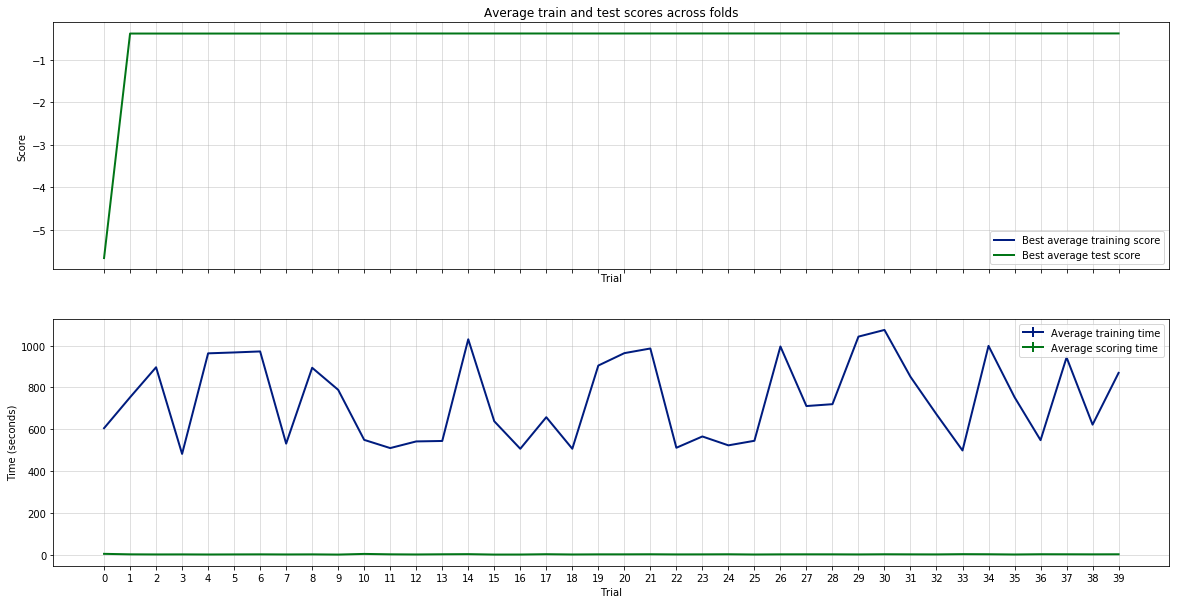

In [18]:
spearmint_opt.history_.plot()

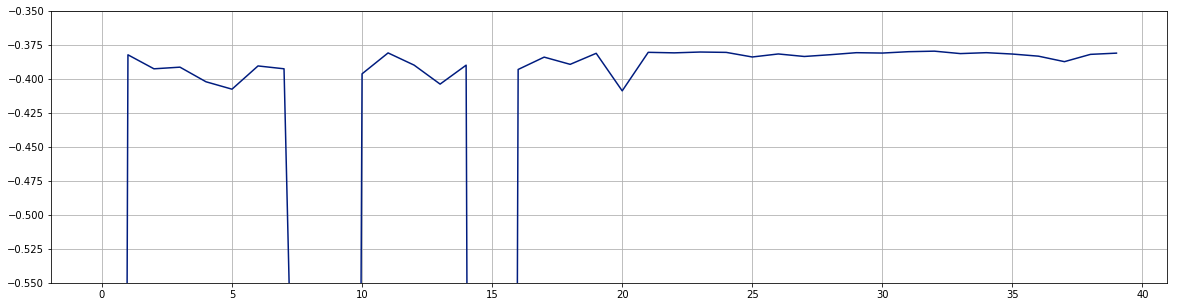

In [19]:
draw_avg_test_score(spearmint_opt.history_)

In [24]:
spearmint_opt.best_test_score_

-0.37955287444602426

In [25]:
spearmint_opt.best_estimator_

XGBoostEstimator(colsample_bytree=0.6805165973973338, gamma=0.857659239811464,
         learning_rate=0.09638754769071428, reg_lambda=0.7750762056442211)

In [20]:
import pandas as pd
import pickle

spearmint_df = pd.DataFrame(data=[dict(**(e.params), avg_test_score=e.test_scores[0],
                                       avg_train_score=e.train_scores[0],
                                       avg_fit_time=e.fit_times[0],
                                       avg_score_time=e.score_times[0]) for e in spearmint_opt.history_.entries])
spearmint_df = spearmint_df.sort_values('avg_test_score', ascending=False)
spearmint_df.to_csv('models/spearmint.csv')

with open('models/spearmint.pkl', 'wb') as f:
    pickle.dump(spearmint_opt, f)
    
spearmint_df

,avg_fit_time,avg_score_time,avg_test_score,avg_train_score,colsample_bytree,gamma,learning_rate,reg_lambda
32,671.444821,1.287397,-0.379553,NaN,0.680517,0.857659,0.096388,0.775076
31,850.975962,1.559742,-0.379944,NaN,0.807894,0.446342,0.101412,0.517738
23,565.490234,1.466181,-0.380188,NaN,0.576232,0.275253,0.084536,1.000000
21,986.437094,1.957526,-0.380414,NaN,1.000000,1.006959,0.093802,1.000000
24,523.051490,1.924886,-0.380455,NaN,0.500396,0.261278,0.087336,0.248744
34,998.964807,2.017117,-0.380667,NaN,1.000000,0.605022,0.109610,0.473260
29,1043.229089,1.157215,-0.380674,NaN,1.000000,2.017925,0.108351,0.988079
22,511.486694,1.241864,-0.380800,NaN,0.500000,0.996904,0.084679,0.678288
11,509.973960,1.707222,-0.380848,NaN,0.500000,0.000000,0.084557,1.000000
30,1075.196254,1.958419,-0.380949,NaN,1.000000,0.172806,0.096237,0.740650


### BayesOptimizer

In [45]:
from hyper_optimizer import BayesOptimizer

t = time.time()
bayes_opt = BayesOptimizer(estimator=XGBoostEstimator(), params=params, 
                           max_trials=40, cv=(Xv, yv), verbose=2, random_state=42, 
                           error_score='raise', acquisition_func='ei')
bayes_opt.fit(Xtr, ytr)
print('Total time: {}'.format(time.time() - t))

Initialization
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   base_score |   colsample_bylevel |   colsample_bytree |     gamma |   learning_rate |   reg_alpha |   reg_lambda |   scale_pos_weight |   subsample | 
[0]	train-rmse:4.86016
Will train until train-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.599082
[99]	train-rmse:0.365657
    1 | 05m39s |   -0.38435 |       1.4374 |              0.8861 |             0.8928 |    0.0959 |          0.0459 |      0.1593 |       0.5341 |             0.9364 |      0.5110 | 
[0]	train-rmse:4.51783
Will train until train-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.352915
[99]	train-rmse:0.342826
    2 | 04m45s |   -0.37650 |       1.3931 |              0.7095 |             0.7535 |    0.0353 |          0.1212 |      0.5281 |       0.5155 |             1.3299 |      0.

[0]	train-rmse:4.20493
Will train until train-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.356105
[99]	train-rmse:0.348972
   24 | 04m05s |   -0.38129 |       1.2803 |              0.7623 |             1.0000 |    0.0000 |          0.2000 |      0.0000 |       0.0000 |             1.7030 |      0.5000 | 
[0]	train-rmse:5.86607
Will train until train-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.381264
[99]	train-rmse:0.348361
   25 | 04m54s |   -0.37712 |       0.1752 |              0.6775 |             0.5012 |    0.0466 |          0.0754 |      0.6381 |       0.2729 |             1.8733 |      0.9133 | 
[0]	train-rmse:4.35874
Will train until train-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.351169
[99]	train-rmse:0.342981
   26 | 05m06s |   -0.37796 |       1.3509 |              0.8284 |             0.7828 |    0.0516 |          0.1593 |      0.7075 |       0.5920 |             0.5078 |      0.7609 | Warning: Test point chose at random due to repeated sample.

[0]	train-rmse:5.21932
Will train until train-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.36059
[99]	train-rmse:0.35162
   50 | 04m40s |   -0.38032 |       0.0000 |              0.5000 |             1.0000 |    0.1000 |          0.2000 |      1.0000 |       1.0000 |             0.3000 |      0.5000 | 
[0]	train-rmse:3.96064
Will train until train-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.361086
[99]	train-rmse:0.351748
   51 | 04m18s |   -0.38029 |       1.5917 |              0.5000 |             0.5000 |    0.1000 |          0.2000 |      1.0000 |       0.6069 |             0.5637 |      0.5000 | 
[0]	train-rmse:3.63852
Will train until train-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.341904
[99]	train-rmse:0.330491
   52 | 05m28s |   -0.37642 |       2.0000 |              1.0000 |             0.5000 |    0.1000 |          0.2000 |      1.0000 |       0.0000 |             1.0257 |      1.0000 | 
[0]	train-rmse:3.63791
Will train until train-rmse hasn't im

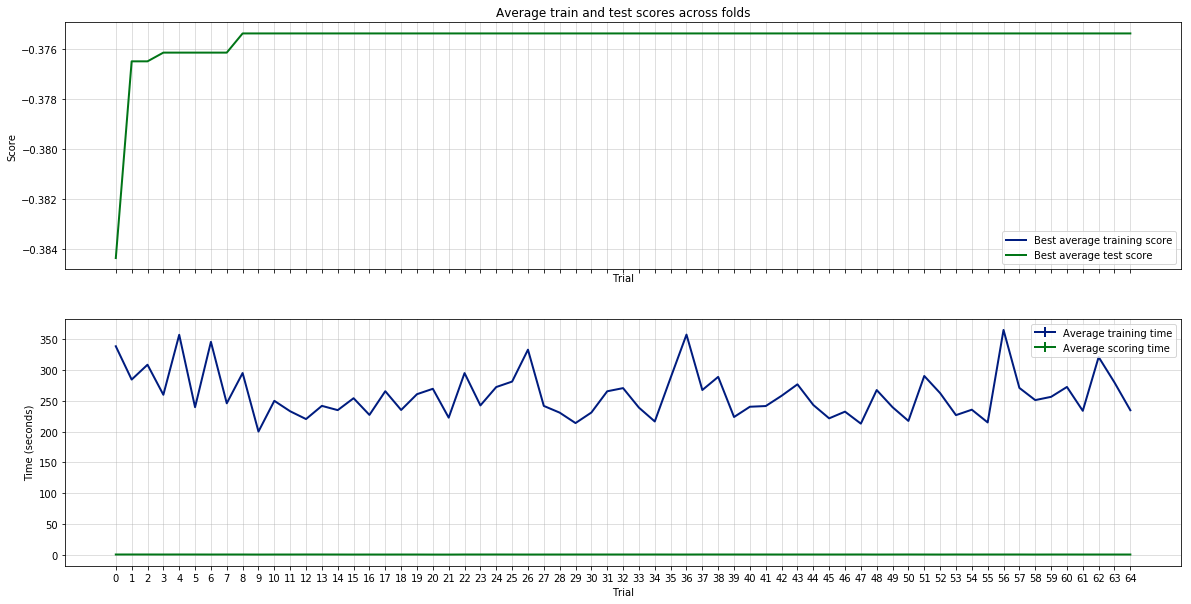

In [46]:
bayes_opt.history_.plot()

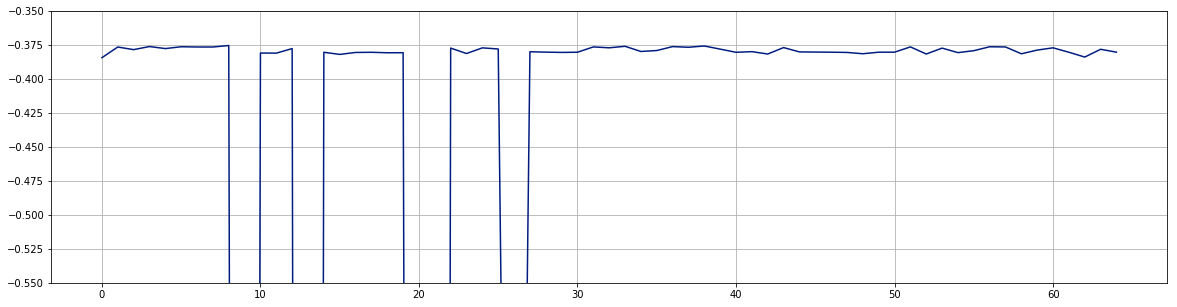

In [50]:
y = [e.test_scores[0] for e in bayes_opt.history_.entries]
f = plt.figure(figsize=(20, 5))
plt.plot(range(len(bayes_opt.history_.entries)), y)
plt.ylim(-0.55, -0.35)
plt.grid()
f

In [52]:
bayes_opt.best_test_score_

-0.37538974190856289

In [53]:
bayes_opt.best_estimator_

XGBoostEstimatorContinuous(base_score=1.6511797850819114,
              colsample_bylevel=0.96408710108715756,
              colsample_bytree=0.50000015823824073,
              gamma=2.460778740664446e-08,
              learning_rate=0.10606359242872597,
              reg_alpha=0.83477745830723182,
              reg_lambda=0.63775678184518769,
              scale_pos_weight=0.77133778314517665, subsample=1.0)

### SigOpt

In [ ]:
from hyper_optimizer import SigOptOptimizer
import time

# leave `subsample=1` as default, as we can only do 4 variables with SigOpt

sigopt_params = [p for p in params if p.name != 'subsample']
t = time.time()
sigopt_opt = SigOptOptimizer(estimator=XGBoostEstimator(), params=sigopt_params, max_trials=40, cv=(Xv, yv),
                             random_state=42, api_token='WJDDUXIXMJHTZCMEKDGWIMMAJCODKPCNLCQWALVMGCWVHQON', n_jobs=20)
sigopt_opt.fit(Xtr, ytr)
print('Total time: {}'.format(time.time() - t))

[0]	train-rmse:4.05677
Will train until train-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.260849
[99]	train-rmse:0.257002
[0]	train-rmse:4.70166
Will train until train-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.113761
[99]	train-rmse:0.079138
[0]	train-rmse:6.00489
Will train until train-rmse hasn't improved in 50 rounds.
[50]	train-rmse:5.31258
[99]	train-rmse:4.71231
[0]	train-rmse:5.01867
Will train until train-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.247466
[99]	train-rmse:0.239456
[0]	train-rmse:4.59804
Will train until train-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.267688
[99]	train-rmse:0.2638
[0]	train-rmse:4.46808
Will train until train-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.208267
[99]	train-rmse:0.202267
[0]	train-rmse:4.668
Will train until train-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.258267
[99]	train-rmse:0.252919
[0]	train-rmse:4.14685
Will train until train-rmse hasn't improved in 50 rounds.
[50]	tra